In [1]:
import mindspore
mindspore.set_context(device_target='CPU')
# mindspore.set_context(device_target='GPU')
# mindspore.set_context(device_target="Ascend")
# mindspore.set_context(device_id=0)
mindspore.run_check()


MindSpore version:  2.1.0
The result of multiplication calculation is correct, MindSpore has been installed on platform [CPU] successfully!


# 4 从头开始实现 GPT 模型来生成文本

在前几章中，我们已经详细学习了文本处理的基础和注意力机制的原理与实现。现在，我们将这些知识整合起来，构建一个完整的生成式预训练Transformer (GPT)模型。GPT模型是现代大语言模型的基础架构，通过掌握它的实现原理，我们可以深入理解当前最先进的语言模型是如何工作的。

本章将从零开始逐步构建GPT模型的各个组件，并将它们组装成一个能够生成连贯文本的完整系统。我们将着手编写LLM的核心构建模块，如层归一化、前馈网络和Transformer块，最终实现一个小型但功能完整的GPT模型。

<img src="./images_llm/fig4.1.svg" width='600'>


## 4.1 编写 LLM 架构

大语言模型(LLMs)如GPT-3、LLaMA和PaLM通常包含数十亿甚至数千亿参数，这使它们在人类眼中显得极其庞大和复杂。然而，尽管这些模型的规模令人生畏，但其基础架构相对简单且高度重复。它们主要由相同的Transformer块堆叠而成，每个块负责处理不同抽象层次的信息。

这种模块化设计使得LLM可以通过简单地增加这些基本构建块的数量来扩展规模，而不需要从根本上改变其架构。正是这种可扩展性使得模型能够从最初的数百万参数扩展到现在的数千亿参数。
    

<img src='./images_llm/fig4.2.svg' width='400'>

我们将编写最小的 GPT-2 模型（1.24 亿参数）的架构，通过以下 Python 字典指定模型的配置。这种配置驱动的设计方法具有很强的灵活性，我们只需调整这些参数值，就可以实现不同规模和能力的GPT模型：

In [2]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

在 GPT_CONFIG_124M 词典中，以下是对一些变量名的详细解释：

1. **vocab_size** (50257): 词汇表大小，指的是BPE分词器使用的词汇量。这个特定的数字来自于GPT-2原始实现，包含了常见英文单词、子词单元和特殊标记。

2. **context_length** (1024): 模型可以处理的最大序列长度。这决定了模型一次能够"看到"和处理的文本量，对于理解长文本和维持上下文连贯性至关重要。

3. **emb_dim** (768): 嵌入维度，每个词元转换为多维向量表示的维度。较高的维度允许模型捕捉更丰富的语义信息，但也增加了计算成本。

4. **n_heads** (12): 多头注意力机制中的注意力头数量。多头设计使模型能够同时关注序列中的不同信息模式，从而增强模型的表达能力。

5. **n_layers** (12): 模型中堆叠的Transformer块数量。更多的层可以处理更复杂的模式和抽象表示，但也增加了模型的深度和训练难度。

6. **drop_rate** (0.1): Dropout比率，用于防止过拟合的正则化技术。在训练过程中随机"丢弃"10%的神经元，迫使网络学习更强健的特征。

7. **qkv_bias** (False): 是否在查询(Q)、键(K)和值(V)的线性变换中包含偏置项。添加偏置可以增加模型的灵活性，但也增加了参数量。

使用此配置，我们将实现一个简化的、用于演示或测试目的的 GPT架构（Dummy GPTModel），如图所示。这个示例模型展示了GPT的基本结构，包括词元嵌入、位置嵌入、Transformer块堆叠和输出层，但内部核心组件（如Transformer块）仅作为占位符。在后续小节中，我们将逐步实现这些核心组件。
    
<img src="./images_llm/fig4.3.svg" width='600'>

In [3]:
import mindspore
import mindspore.nn as nn
import mindspore.ops as ops

class DummyGPTModel(nn.Cell):
    def __init__(self, cfg):
        super(DummyGPTModel, self).__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(p=cfg["drop_rate"])

        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.SequentialCell(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        # Use a placeholder for LayerNorm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Dense(
            cfg["emb_dim"], cfg["vocab_size"], has_bias=False
        )

    def construct(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(ops.arange(seq_len))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


class DummyTransformerBlock(nn.Cell):
    def __init__(self, cfg):
        super(DummyTransformerBlock, self).__init__()
        # A simple placeholder

    def construct(self, x):
        # This block does nothing and just returns its input.
        return x


class DummyLayerNorm(nn.Cell):
    def __init__(self, normalized_shape, eps=1e-5):
        super(DummyLayerNorm, self).__init__()
        # The parameters here are just to mimic the LayerNorm interface.

    def construct(self, x):
        # This layer does nothing and just returns its input.
        return x

<img src="./images_llm/fig4.4.svg" width='600'>

上图展示了GPT模型的基本数据流程。输入的词元ID首先被转换为嵌入向量，然后与位置嵌入相加以保留序列中的位置信息。经过Dropout处理后，数据流经多个Transformer块，每个块进一步处理和转换表示。最后，通过一个线性层将结果映射到词汇表大小的输出，生成每个可能词元的概率分布。

在接下来的部分中，我们将逐步实现这个架构中的各个核心组件，最终组装成一个完整的、功能性的GPT模型。

In [4]:
from transformers import GPT2Tokenizer
from mindspore import Tensor
# 指定本地词汇表文件所在的目录路径
local_path = "./gpt2-tokenizer"

# 从本地路径加载GPT - 2分词器
tokenizer = GPT2Tokenizer.from_pretrained(local_path)

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(Tensor(tokenizer.encode(txt1)))
batch.append(Tensor(tokenizer.encode(txt2)))
batch = ops.stack(batch, axis=0)
print(batch)

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


[[6109 3626 6100  345]
 [6109 1110 6622  257]]


In [5]:
mindspore.set_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)

logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: (2, 4, 50257)
[[[ 3.4227250e-03  7.4077314e-03 -1.7565343e-03 ...  1.7987960e-04
   -2.8054556e-04  6.2894425e-03]
  [-1.6051477e-02 -6.9802068e-04  5.9053577e-03 ...  1.0963629e-02
   -1.1396457e-02 -1.0390200e-02]
  [-7.0738825e-03  7.5644581e-03 -9.0161264e-03 ... -8.5941190e-04
   -2.0665708e-03 -4.1220831e-03]
  [ 1.3805581e-03 -1.0841140e-02 -4.0423525e-03 ...  5.1172962e-04
    2.9840767e-03 -2.8948567e-03]]

 [[ 3.4227250e-03  7.4077314e-03 -1.7565343e-03 ...  1.7987960e-04
   -2.8054556e-04  6.2894425e-03]
  [ 4.9724570e-04  2.1194271e-03  8.8037616e-03 ...  9.2625152e-05
   -9.1164280e-03 -1.5153075e-02]
  [-3.3303255e-03  4.1079315e-04 -4.1647851e-03 ...  3.4606953e-03
    1.1678563e-03 -7.5262091e-03]
  [-5.1538306e-03 -1.1113978e-02  1.1534748e-02 ...  5.0090058e-03
    1.2650667e-02 -3.3001843e-04]]]


## 4.2 使用层归一化对激活值归一化

深度神经网络在训练过程中经常面临梯度消失或爆炸等问题，这些问题会导致训练不稳定，收敛缓慢甚至失败。层归一化(Layer Normalization)是一种强大的技术，可以缓解这些问题，使深度网络训练更加稳定和高效。

与批归一化(Batch Normalization)不同，层归一化在单个样本内部进行操作，而不是跨批次样本。这使得它特别适合处理序列数据和变长输入，因此在Transformer架构中被广泛采用。层归一化的核心思想是将每一层的激活值调整为均值为0、方差为1的标准分布，然后通过可学习的缩放和偏移参数进行调整，使网络能够学习最适合任务的数据分布。
    

<img src='./images_llm/fig4.5.svg' width='600'>

In [6]:
mindspore.set_seed(123)

# create 2 training examples with 5 dimensions (features) each
batch_example = ops.randn(2, 5) 

layer = nn.SequentialCell(nn.Dense(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

[[0.10539116 0.         0.         0.         0.4322223  0.        ]
 [0.2584788  0.         0.31767976 0.         0.         0.        ]]


In [7]:
import mindspore.numpy as np

mean = np.mean(out, axis=-1, keepdims=True)
var = np.var(out, axis=-1, keepdims=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 [[0.08960224]
 [0.09602642]]
Variance:
 [[0.02495868]
 [0.01873421]]


均值张量中，第一行表示第一个输入样本各输出的平均值，第二行则表示第二个输入样本各输出的平均值。在计算均值或方差等操作时，使用keepdim=True参数可以确保输出张量保持与输入张量相同的维度，以便于后续的广播操作。

层归一化的计算过程可以简化为以下几个步骤：

1. 计算每个样本特征的均值和方差
2. 使用均值和方差对样本特征进行标准化(z-score归一化)
3. 应用可学习的缩放和偏移参数，恢复表达能力

下图展示了层归一化的数学计算过程，其中每一步都对应于上述的操作步骤：

<img src="./images_llm/fig4.6.svg" width='600'>

对层输出进行归一化操作需要两个关键步骤：首先减去对应维度的平均值（中心化），然后除以方差的平方根（标准差）实现标准化：

In [8]:
out_norm = (out - mean) / np.sqrt(var)
print("Normalized layer outputs:\n", out_norm)

mean = np.mean(out_norm, axis=-1, keepdims=True)
var = np.var(out_norm, axis=-1, keepdims=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 [[ 0.09994053 -0.5671632  -0.5671632  -0.5671632   2.1687126  -0.5671632 ]
 [ 1.1868842  -0.70157325  1.6194091  -0.70157325 -0.70157325 -0.70157325]]
Mean:
 [[3.973643e-08]
 [3.973643e-08]]
Variance:
 [[0.99999994]
 [1.0000001 ]]


避免科学计数法显示非常小的数值，可以使用特定的打印选项，使结果更易于阅读：

In [9]:
import numpy
numpy.set_printoptions(suppress=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 [[0.00000004]
 [0.00000004]]
Variance:
 [[0.99999994]
 [1.0000001 ]]


到目前为止，我们已经逐步实现了层归一化的核心计算过程。为了方便在后续模型中使用，我们将这个过程封装成一个完整的Mindspore模块。这样的封装不仅提高了代码的可读性和可重用性，也与深度学习框架的设计理念保持一致。

In [10]:
class LayerNorm(nn.Cell):
    def __init__(self, emb_dim):
        super(LayerNorm, self).__init__()
        self.eps = 1e-5
        self.scale = mindspore.Parameter(ops.ones(emb_dim, dtype=mindspore.float32))
        self.shift = mindspore.Parameter(ops.zeros(emb_dim, dtype=mindspore.float32))

    def construct(self, x):
        mean = np.mean(x, axis=-1, keepdims=True)
        var = np.var(x, axis=-1, keepdims=True)
        norm_x = (x - mean) / np.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

这种特定的层规范化方法是针对输入张量$x$的最后一个维度进行操作的，该维度通常代表嵌入维度（emb_dim）。在规范化过程中，我们引入了一个极小常数 eps（即 epsilon），将其添加到方差中，以避免因方差为零而导致的除零错误，增强数值稳定性。

层规范化还引入了两个可训练参数：比例参数（scale）和偏移参数（shift），它们的维度与输入张量的最后一个维度保持一致。这些参数允许模型学习每个特征的最佳缩放和偏移量，使得归一化后的表示能够保持足够的表达能力。在模型训练过程中，语言模型（LLM）会自动优化这些参数；如果调整它们能够提升模型在特定任务上的表现，模型就会学习到最适合当前数据的缩放和偏移方式。

这种设计不仅增强了模型的灵活性，还使其能够更好地适应不同数据分布，从而提升整体性能。需要注意的是，层归一化在Transformer架构中起着至关重要的作用，它不仅稳定了训练过程，还加速了收敛速度。
  

In [11]:
ln = LayerNorm(emb_dim=5) 
out_ln = ln(batch_example) 
mean = np.mean(out_ln, axis=-1, keepdims=True) 
var = np.var(out_ln, axis=-1, keepdims=True) 
print("Mean:\n", mean) 
print("Variance:\n", var)

Mean:
 [[-0.00000007]
 [-0.00000001]]
Variance:
 [[0.9999264]
 [0.9999944]]


<img src="./images_llm/fig4.7.svg" width='600'>

上图展示了层归一化在Transformer块中的应用位置。在现代GPT模型中，层归一化通常应用于多头注意力机制和前馈网络之前（称为Pre-LayerNorm），这种配置有助于稳定深度Transformer网络的训练。原始Transformer论文中采用的是Post-LayerNorm（在子模块后应用归一化），但研究表明Pre-LayerNorm对于训练非常深的模型更为有效，因此被广泛采用在现代架构中。

## 4.3 使用 GELU 激活实现前馈网络

激活函数是神经网络中引入非线性的关键元素，使网络能够学习复杂的模式和关系。在Transformer架构中，前馈神经网络(Feed-Forward Network, FFN)层使用非线性激活函数处理经过注意力机制后的表示，进一步提取和转换特征。

接下来，我们将着手实现一个前馈神经网络子模块，作为LLM中Transformer块的重要组成部分。我们首先实现GELU(Gaussian Error Linear Unit)激活函数，这是现代语言模型中最常用的激活函数之一。

ReLU(Rectified Linear Unit)激活函数因其简洁性和有效性，在深度学习领域得到了广泛应用。然而，在大型语言模型中，除了传统的ReLU函数外，GELU和SwiGLU等更复杂的激活函数表现出了更优的性能。

GELU和SwiGLU是更平滑的激活函数，GELU融合了高斯累积分布函数的特性，而SwiGLU则结合了S型（sigmoid）门控和线性单元。与简单的ReLU相比，这些更复杂的激活函数能够更好地捕捉数据的非线性特征，提供了在梯度传播和表达能力之间的平衡，因此在现代语言模型中被广泛采用。

GELU激活函数的精确数学定义为 GELU(x)=xΦ(x)，其中 Φ(x) 是标准高斯分布的累积分布函数。为了计算效率，在实践中通常使用下面的近似公式，这也是GPT-2模型使用的版本：

$$
\text{GELU}(x)  \approx 0.5 \cdot x \cdot \left(1 + \tanh\left[\sqrt{\frac{2}{\pi}} \cdot (x + 0.044715 \cdot x^3)\right]\right)
$$

这个近似公式通过曲线拟合得到，提供了计算上更为高效的实现方式，同时保持了GELU的关键特性。

In [12]:
class GELU(nn.Cell):
    def __init__(self):
        super(GELU, self).__init__()


    def construct(self, x):
        return 0.5 * x * (1 + np.tanh(
            np.sqrt(Tensor(2.0 / np.pi)) * (x + 0.044715 * ops.pow(x, 3))
        ))

In [13]:
#!pip install matplotlib

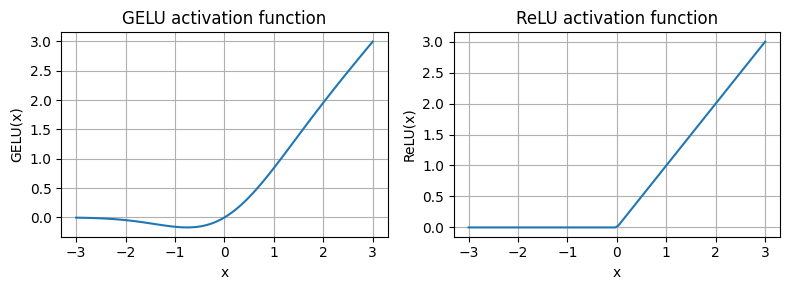

In [14]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# Some sample data
x = ops.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

ReLU函数（位于右侧）是一个分段线性函数，当输入为正数时，它直接输出输入值；而当输入为负数时，则输出零。这种特性使得ReLU在负值区域的梯度为零，可能导致一些神经元"死亡"（永远不被激活）。

相比之下，GELU函数（位于左侧）展现出一个平滑的非线性特性，形态上近似于ReLU，但对于负值输入也能提供非零的梯度（除了极少数点）。这种平滑特性使得GELU在不同输入范围内都能进行有效的梯度传播，减少了神经元死亡的问题，并对噪声输入具有更好的鲁棒性。

GELU的这些特性使其在处理语言数据时表现出色，因为语言数据往往包含复杂的结构和关系，需要激活函数能够捕捉微妙的非线性模式。这也是为什么GELU成为现代语言模型中主流激活函数的原因之一。
  

In [15]:
class FeedForward(nn.Cell):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.SequentialCell(
            nn.Dense(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Dense(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def construct(self, x):
        return self.layers(x)

In [16]:
print(GPT_CONFIG_124M["emb_dim"])

768


<img src="./images_llm/fig4.8.svg" width='400'>

前馈网络是Transformer块中的关键组件，通常跟随在多头注意力机制之后。它由两个线性变换组成，中间使用非线性激活函数（在这里是GELU）连接。这种结构可以被解释为一个位置级的特征处理器，其工作流程如下：

1. 第一个线性层将输入从嵌入维度扩展到更大的中间维度（通常是嵌入维度的4倍），增加了模型的表达能力
2. GELU激活函数引入非线性，使网络能够学习复杂的模式
3. 第二个线性层将维度压缩回原始的嵌入维度，整合处理后的特征

这种设计允许模型在每个位置上独立地处理和转换特征，补充了多头注意力机制捕获的序列内依赖关系，从而增强了模型的整体表达能力。
 

In [17]:
ffn = FeedForward(GPT_CONFIG_124M)

# input shape: [batch_size, num_token, emb_size]
x = ops.rand(2, 3, 768) 
out = ffn(x)
print(out.shape)

(2, 3, 768)


前馈模块可以增强模型从数据中学习和泛化的能力。它的特点是首先通过第一个线性层将嵌入维度扩展到更高维空间（通常是原始维度的4倍），这种扩展提供了更丰富的表达空间；随后应用非线性GELU激活，引入复杂的非线性变换；最后通过第二个线性变换将维度缩减回原始大小，整合和压缩学到的特征表示。

简而言之，前馈网络可以看作是对每个位置表示的"深度处理"步骤，它补充了注意力机制的"宽度处理"（跨位置的信息交互），两者共同构成了Transformer块的强大学习能力。
    
<img src="./images_llm/fig4.9.svg" width='600'>

## 4.4 添加快捷连接

快捷连接（Skip Connection，也称为残差连接Residual Connection）是深度神经网络中的一项关键创新，最初由He等人在ResNet架构中提出。它解决了深度网络训练过程中的一个基本问题：随着网络深度增加，梯度在反向传播过程中趋于消失，导致浅层难以有效学习。

这一问题在Transformer等深度架构中尤为严重，因为它们通常包含大量堆叠的层。快捷连接通过在网络中创建额外的路径，允许信息和梯度直接跳过一个或多个层，从而有效地缓解了梯度消失问题。

如图所示，快捷连接的实现非常简单：将层的输入直接添加到该层的输出上。这种简单的加法操作创建了一条梯度流动的"高速公路"，使得深层网络更容易训练，同时保持了网络的表达能力。
    
<img src="./images_llm/fig4.10.svg" width='600'>


In [18]:
class ExampleDeepNeuralNetwork(nn.Cell):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.CellList([
            nn.SequentialCell(nn.Dense(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.SequentialCell(nn.Dense(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.SequentialCell(nn.Dense(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.SequentialCell(nn.Dense(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.SequentialCell(nn.Dense(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def construct(self, x):
        for layer in self.layers:
            # Compute the output of the current layer
            layer_output = layer(x)
            # Check if shortcut can be applied
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x


def print_gradients(model, x):

    def forward(x):
        # 前向传播
        output = model(x)
        target = Tensor([[0.]])

        # 基于目标值和输出值计算损失
        loss = nn.MSELoss()
        loss = loss(output, target)

        return loss
    
    # 反向传播
    grad_fn = mindspore.value_and_grad(forward, None, weights=model.trainable_params())
    loss, grads = grad_fn(x)
    for param, grad in zip(model.trainable_params(), grads):
        if 'weight' in param.name:
            # 打印权重的平均绝对梯度
            print(f"{param.name} has gradient mean of {grad.abs().mean().asnumpy()}")

如果不添加快捷连接，即设置`use_shortcut=False`，我们会观察到深度网络中典型的梯度消失现象。随着层数的增加，浅层（如layers.0）的梯度值明显小于深层（如layers.4），这意味着较深层获得了更有效的更新，而浅层学习变得非常缓慢。

In [19]:
layer_sizes = [3, 3, 3, 3, 3, 1]  

sample_input = Tensor([[1., 0., -1.]])

mindspore.set_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 5.775319368694909e-05
layers.1.0.weight has gradient mean of 0.00013170905003789812
layers.2.0.weight has gradient mean of 0.00036027480382472277
layers.3.0.weight has gradient mean of 0.00284433807246387
layers.4.0.weight has gradient mean of 0.07787459343671799


设置`use_shortcut=True`激活快捷连接后，我们可以观察到显著的改进：浅层的梯度值得到了明显提升，与深层的差距大幅缩小。这表明快捷连接成功地允许梯度在网络中更加均匀地流动，使得网络的所有部分都能得到有效的学习。

In [20]:
mindspore.set_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.038417913019657135
layers.1.0.weight has gradient mean of 0.03854157030582428
layers.2.0.weight has gradient mean of 0.022813601419329643
layers.3.0.weight has gradient mean of 0.03126213699579239
layers.4.0.weight has gradient mean of 0.7397494912147522


最后一层（`layers.4`）的梯度值仍然比其他层大，这是正常的，因为它直接连接到损失函数。然而，关键的改进是随着我们向第一层（`layers.0`）递进，梯度值保持在一个合理的范围内，没有急剧缩减至极小的值。这清晰地表明，快捷连接在缓解深度神经网络中的梯度消失问题方面发挥着至关重要的作用。

在Transformer架构中，快捷连接被广泛应用于多头注意力机制和前馈网络模块。这些连接不仅使得非常深的模型（如拥有数十甚至上百层的大型语言模型）能够被有效训练，还为模型提供了学习身份映射的能力，使其能够在必要时"跳过"某些变换，增强了架构的灵活性和适应性。

## 4.5 在 transformer 模块中连接注意力层和线性层

现在，我们已经实现了Transformer架构的核心组件：多头注意力机制、层归一化、前馈网络和快捷连接。接下来，我们将这些组件整合成完整的Transformer模块，这是GPT及其他现代语言模型的基本构建单元。

Transformer模块是一个精心设计的组合，它有效地融合了信息处理的多个关键步骤：通过多头注意力机制捕获序列内的依赖关系，通过前馈网络处理每个位置的特征，并通过层归一化和快捷连接确保训练的稳定性和有效性。

在拥有1.24亿参数的GPT-2架构中，这个模块被重复堆叠12次，每一层都在更抽象的层次上处理和转换序列表示。下图展示了Transformer模块的内部结构及其在GPT架构中的位置：
    
<img src="./images_llm/fig4.11.svg" width='500'>

In [27]:
class MultiHeadAttention(nn.Cell):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super(MultiHeadAttention, self).__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Dense(d_in, d_out, has_bias=qkv_bias)
        self.W_key = nn.Dense(d_in, d_out, has_bias=qkv_bias)
        self.W_value = nn.Dense(d_in, d_out, has_bias=qkv_bias)
        self.out_proj = nn.Dense(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(p=dropout)
        # 创建掩码矩阵
        ones_matrix = ops.ones((context_length, context_length), mindspore.float32)
        mask = ops.triu(ones_matrix, diagonal=1)
        self.mask = mindspore.Parameter(mask, requires_grad=False)

    def construct(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # 重塑张量以分离头
        keys = ops.reshape(keys, (b, num_tokens, self.num_heads, self.head_dim))
        values = ops.reshape(values, (b, num_tokens, self.num_heads, self.head_dim))
        queries = ops.reshape(queries, (b, num_tokens, self.num_heads, self.head_dim))

        # 交换维度
        keys = ops.transpose(keys, (0, 2, 1, 3))
        queries = ops.transpose(queries, (0, 2, 1, 3))
        values = ops.transpose(values, (0, 2, 1, 3))

        # 计算注意力分数
        keys_transposed = ops.transpose(keys, (0, 1, 3, 2))
        attn_scores = ops.matmul(queries, keys_transposed)

        # 准备掩码
        mask_bool = self.mask[:num_tokens, :num_tokens].astype(mindspore.bool_)
        neg_inf = mindspore.Tensor(-float('inf'), dtype=mindspore.float32)
        attn_scores = ops.masked_fill(attn_scores, mask_bool, neg_inf)

        # 计算注意力权重
        scale_factor = keys.shape[-1] ** 0.5
        scaled_attn_scores = attn_scores / scale_factor
        softmax = nn.Softmax(axis=-1)
        attn_weights = softmax(scaled_attn_scores)
        attn_weights = self.dropout(attn_weights)

        # 计算上下文向量
        context_vec = ops.matmul(attn_weights, values)
        context_vec = ops.transpose(context_vec, (0, 2, 1, 3))
        
        # 合并头
        context_vec = ops.reshape(context_vec, (b, num_tokens, self.d_out))
        context_vec = self.out_proj(context_vec)

        return context_vec

In [28]:
# from chapter03 import MultiHeadAttention


class TransformerBlock(nn.Cell):
    def __init__(self, cfg):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(p=cfg["drop_rate"])

    def construct(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x

上述代码定义了一个 `TransformerBlock` 类，这是GPT模型的核心构建块。它采用了以下架构特性：

1. **多头注意力机制(MultiHeadAttention)** ：使用多个注意力头并行处理输入，每个头关注序列中的不同模式。

2. **前馈网络(FeedForward)** ：包含两个线性层和GELU激活函数，为每个位置独立地进行非线性特征变换。

3. **层归一化(LayerNorm)** ：在每个子模块（注意力机制和前馈网络）之前应用，采用Pre-LayerNorm设计，与原始Transformer的Post-LayerNorm不同，这种设计在训练深层模型时表现更为稳定。

4. **快捷连接(Shortcut Connection)** ：在每个子模块前后应用，允许梯度直接流过网络，缓解梯度消失问题，同时使模型能够保留输入信息。

5. **Dropout**：应用于子模块的输出，随机"丢弃"一部分神经元，作为正则化技术防止过拟合。

在前向传播过程中，输入数据首先通过层归一化，然后进入多头注意力机制。注意力机制的输出经过Dropout处理后，与原始输入相加（快捷连接）。然后，这个中间结果再次经过层归一化，进入前馈网络，其输出同样经过Dropout处理后与中间结果相加（又一个快捷连接）。这种精心设计的数据流使得深层Transformer网络能够有效学习和保持长距离依赖关系，同时保持训练的稳定性。
  

使用我们之前定义的 `GPT_CONFIG_124M` 字典实例化一个 `Transformer` 块并为其提供一些样本数据：

In [29]:
mindspore.set_seed(123)

x = ops.rand(2, 4, 768)  # Shape: [batch_size, num_tokens, emb_dim]
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: (2, 4, 768)
Output shape: (2, 4, 768)



可以看到，Transformer块保持了输入的形状（批次大小×序列长度×嵌入维度），但对内容进行了非线性变换。这种"形状保持"的特性使得Transformer块可以被方便地堆叠，构建任意深度的网络，而不需要额外的维度调整。在GPT模型中，多个相同的Transformer块依次处理数据，每一层都在前一层的基础上提取更高级别的特征和模式。

## 4.6 GPT 模型

在本章的开篇，我们对GPT架构进行了全面的概述，并引入了一个名为DummyGPTModel的示例实现。这个实现展示了GPT模型的整体结构，但其核心组件（如TransformerBlock和LayerNorm）仅作为没有实际功能的占位符。

现在，我们已经实现了所有必要的组件，可以将它们组装成一个完整的、功能性的GPT模型。我们将使用之前编写的TransformerBlock和LayerNorm类，替代DummyGPTModel中的占位符，构建一个具有1.24亿参数的GPT-2模型。

GPT模型的整体架构如下图所示，包括嵌入层、Transformer块堆叠和输出头。这种设计允许模型将输入文本转换为连续向量表示，通过多层Transformer处理捕获复杂的语言模式，最终生成每个可能词元的概率分布。

<img src="./images_llm/fig4.12.svg" width='450'>

我们实现的GPTModel类具有以下关键组件：

1. **词元嵌入(tok_emb)** ：将输入的词元ID转换为高维向量表示，捕获词元的语义特征。

2. **位置嵌入(pos_emb)** ：为每个位置提供一个唯一的向量表示，使模型能够区分不同位置的相同词元。

3. **嵌入Dropout(drop_emb)** ：应用于嵌入层的输出，作为正则化手段防止过拟合。

4. **Transformer块堆叠(trf_blocks)** ：多个相同的Transformer块连续处理数据，每个块包含多头注意力机制和前馈网络。

5. **最终层归一化(final_norm)** ：在输出头之前应用的归一化层，确保输出特征分布的稳定性。

6. **输出头(out_head)** ：将最终的特征表示映射到词汇表大小的向量，每个元素表示对应词元的得分（logits）。

在前向传播过程中，模型首先将输入ID转换为嵌入向量，并添加位置信息；然后经过一系列Transformer块的处理；最后通过线性层将结果映射到词汇表空间，得到每个可能词元的未归一化对数概率（logits）。这些logits可以直接用于训练（计算损失）或生成（通过采样下一个词）。

这种端到端的架构设计使GPT模型能够理解并生成连贯、流畅的文本，捕捉语言中的长距离依赖关系和复杂语义模式，为各种自然语言处理任务提供强大的基础。
   

In [30]:
class GPTModel(nn.Cell):
    def __init__(self, cfg):
        super(GPTModel, self).__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(p=cfg["drop_rate"])

        self.trf_blocks = nn.SequentialCell(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Dense(
            cfg["emb_dim"], cfg["vocab_size"], has_bias=False
        )

    def construct(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_indices = Tensor(np.arange(seq_len), dtype=mindspore.int32)
        pos_embeds = self.pos_emb(pos_indices)
        pos_embeds = mindspore.ops.expand_dims(pos_embeds, 0)
        pos_embeds = mindspore.ops.tile(pos_embeds, (batch_size, 1, 1))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

现在，我们将使用 `GPT_CONFIG_124M` 字典（作为cfg参数传入）来初始化一个具有1.24亿个参数的GPT模型，并将我们之前创建的批量文本输入提供给该模型进行处理：

In [31]:
mindspore.set_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 [[6109 3626 6100  345]
 [6109 1110 6622  257]]

Output shape: (2, 4, 50257)
[[[ 0.31178507 -0.5457619  -0.06643209 ...  0.28932837  0.5990323
   -0.26291043]
  [ 0.21411943 -0.48537663  0.1574881  ...  0.4713522   0.28291106
   -0.22458228]
  [ 0.03199475 -0.49083564  0.13941392 ...  0.4706279   0.30427632
   -0.5071233 ]
  [ 0.0748542  -0.47420925  0.11044836 ...  0.5467526   0.24440886
   -0.5193511 ]]

 [[ 0.31178507 -0.5457619  -0.06643209 ...  0.28932837  0.5990323
   -0.26291043]
  [ 0.36740708 -0.54842234  0.10895526 ...  0.2772324   0.500062
   -0.65989274]
  [ 0.5164281  -0.8352239   0.29712898 ...  0.45427608  0.5243402
   -0.78190607]
  [ 0.5142338  -0.4501591   0.3219374  ...  0.5002439   0.27415723
   -0.6930151 ]]]


通过使用numel()方法（即"number of elements"的简称），我们可以统计出模型参数张量中的总参数个数。这个数字代表了模型的复杂度和表达能力：

In [32]:
total_params = sum(p.numel() for p in model.trainable_params())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


你可能会注意到一个有趣的差异：我们提到要初始化一个具有1.24亿个参数的GPT模型，但实际统计的参数数量却是1.63亿个。这种差异源于原始GPT-2架构中采用的一项称为权重绑定(Weight Tying)的技术。

权重绑定是一种参数共享技术，它通过在模型的不同部分共享相同的权重矩阵来减少参数数量。具体来说，原始GPT-2模型在其输出层中重复使用了来自词元嵌入层的权重矩阵，即tok_emb和out_head使用相同的权重。这种设计基于一个观察：将词嵌入矩阵用作输出投影不仅可以减少参数数量，还能在语言模型训练中提高性能。

这种权重共享不仅减少了参数数量，还提供了一种有用的归纳偏置，使模型在嵌入空间和输出空间中使用一致的表示。在完整的GPT-2实现中，这种权重绑定将我们观察到的1.63亿参数减少到了公开报告的1.24亿参数。
  

In [33]:
print("Token embedding layer shape:", model.tok_emb.embedding_table.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: (50257, 768)
Output layer shape: (50257, 768)


如果考虑权重绑定（即将tok_emb和out_head的权重共享），我们可以计算更准确的参数数量：

In [34]:
total_params_gpt2 =  total_params - sum(p.numel() for p in model.out_head.get_parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


这个数字非常接近原始GPT-2论文中报告的1.24亿参数。一个有趣的观察是，即使拥有超过1亿的参数，模型大小也只有大约622MB。这突显了现代深度学习框架的效率，以及为什么更大规模的模型（如拥有1750亿参数的GPT-3）需要特殊的分布式训练技术和硬件资源。

In [35]:
# Calculate the total size in bytes (assuming float32, 4 bytes per parameter)
total_size_bytes = total_params * 4

# Convert to megabytes
total_size_mb = total_size_bytes / (1024 * 1024)

print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


## 4.7 生成文本 

至此，我们已经构建了一个完整的GPT模型架构。现在，让我们探索如何使用这个模型生成新的文本。生成过程的核心是自回归生成：模型逐个预测序列中的下一个词元，然后将预测的词元添加到输入上下文中，形成一个迭代过程。

在实际应用中，文本生成不仅涉及模型的前向传播，还包括从模型输出的概率分布中采样、处理特殊标记、实现停止条件等。下图展示了生成过程的基本流程：

<img src="./images_llm/fig4.13.svg" width='600'>

GPT模型从输出张量到生成文本的过程涉及多个精细步骤，如图所示。首先，模型接收一个输入上下文（可能只是一个开始词或短语），然后计算词汇表中每个词元作为下一个词的概率。接下来，从这个概率分布中选择一个词元（可以是最高概率的词元，也可以使用温度采样等技术引入随机性）。选择的词元被添加到上下文中，然后重复这个过程，直到达到预定的长度或生成特殊的结束标记。

<img src="./images_llm/fig4.14.svg" width='600'>

In [36]:
import mindspore.context


def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):
        
        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]
        
        # Get the predictions
        # with mindspore.context.grad_off():
        logits = model(idx_cond)
        
        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]  

        # Apply softmax to get probabilities
        softmax = ops.Softmax(axis=-1)
        probas = softmax(logits)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = ops.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = ops.concat((idx, idx_next), axis=1)  # (batch, n_tokens+1)

    return idx

我们实现的`generate_text_simple`函数展示了这个过程的简化版本。该函数有以下关键步骤：

1. **裁剪上下文**：如果当前上下文长度超过模型支持的最大上下文长度，只使用最后一部分作为有效上下文。

2. **获取预测**：将当前上下文输入模型，获取所有可能的下一个词元的logits。

3. **关注最后时间步**：只关注序列中最后一个位置的预测，因为我们只需要预测下一个词元。

4. **转换为概率**：使用softmax函数将logits转换为概率分布。

5. **选择下一个词元**：在这个简单实现中，直接选择概率最高的词元（贪婪解码）。在更复杂的实现中，可以使用温度采样、核采样等策略引入随机性和多样性。

6. **更新上下文**：将选择的词元添加到当前上下文，为下一轮生成做准备。

这个循环继续进行，直到生成指定数量的新词元。虽然这是一个简化的实现，但它捕捉了现代语言模型文本生成的核心流程。


<img src="./images_llm/fig4.15.svg" width='600'>

图中展示了生成过程中的循环：模型接收上下文，预测下一个词元，将预测的词元添加到上下文中，然后重复这个过程。这种自回归生成方式使模型能够产生连贯的、上下文相关的文本输出。

首先，我们需要准备一个起始上下文作为生成的种子。这可以是一个短语、一个问题或者任何文本片段，用于引导模型开始生成过程：

In [37]:
start_context = "Hello, I am"

encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = Tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: (1, 4)


现在，我们使用实现的生成函数，从起始上下文开始生成新的文本。在生成过程中，我们关闭模型的Dropout（通过设置`model.set_train(False)`），因为Dropout是一种训练时的正则化技术，在推理阶段不需要应用：

In [38]:
model.set_train(False) # 关闭 dropout

out = generate_text_simple(
    model=model,
    idx=encoded_tensor, 
    max_new_tokens=6, 
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output:", out)
print("Output length:", len(out[0]))

Output: [[15496    11   314   716 10636 10636 48695 10636 48695 48695]]
Output length: 10


最后，我们将生成的整数ID序列解码回人类可读的文本：

In [39]:
decoded_text = tokenizer.decode(out.squeeze(0))
print(decoded_text)

Hello, I am deputy deputy vacations deputy vacations vacations


可以看到，未经训练的GPT模型生成的文本是不连贯的，它重复生成"deputy"和"vacations"等词汇。这是因为模型的权重是随机初始化的，没有经过任何训练来学习语言的结构和规律。为了生成流畅、连贯和有意义的文本，模型需要在大规模文本语料库上进行预训练，学习语言的统计规律和模式。

在实践中，生成过程可以通过多种技术进一步优化，如：

- **温度采样(Temperature Sampling)** ：通过调整softmax函数的温度参数，控制生成文本的随机性和创造性
- **Top-K采样**：只从概率最高的K个词元中采样，过滤掉低概率选项
- **Top-p采样(Nucleus Sampling)** ：只从累积概率达到阈值p的最小词元集合中采样，平衡多样性和质量
- **束搜索(Beam Search)** ：维护多个候选序列，最终选择整体概率最高的序列

这些技术可以帮助模型生成更流畅、更多样、更有创意的文本，满足不同应用场景的需求。

## 4.8 总结

在本章中，我们从零开始实现了一个完整的GPT模型架构，并探索了其核心组件和工作原理。以下是本章的关键要点：

- **层归一化(Layer Normalization)** 是深度神经网络训练的关键组件，它通过调整每一层的输出，使其均值和方差保持一致，从而稳定了训练过程、加速了收敛并提高了模型性能。在Transformer架构中，层归一化通常应用于子模块的输入（Pre-LayerNorm设计），这种配置比原始Transformer的Post-LayerNorm更适合训练非常深的网络。

- **快捷连接(Skip Connections)** 是处理深度神经网络梯度消失问题的有效技术，通过直接将一层的输入添加到其输出，创建了梯度流动的"高速公路"。在GPT等模型中，这些连接对于训练数十甚至上百层的深度网络至关重要，确保了从输出到输入的有效梯度传播。

- **GELU激活函数**是现代语言模型中的主流选择，它比ReLU提供更平滑的非线性特性，能够更好地处理语言数据中的复杂模式。在前馈网络中，GELU与线性层组合，提供了位置级别的特征处理，补充了注意力机制的序列级信息交互。

- **Transformer块**是GPT模型的核心构建模块，它融合了多头因果注意力机制、前馈网络、层归一化和快捷连接。这个精心设计的模块能够有效地处理序列数据，捕捉长距离依赖关系，并且可以被堆叠到任意深度，构建强大的语言模型。

- **GPT模型架构**由多层堆叠的Transformer块组成，从词元嵌入开始，通过位置编码添加序列信息，然后经过多层Transformer处理，最终通过线性层映射到词汇表空间。这种架构具有不同的规模变体，从1.24亿参数的小型模型到拥有数千亿参数的超大模型，都遵循相同的基本设计原则。

- **文本生成**在GPT等自回归语言模型中是一个迭代过程，模型根据当前上下文预测下一个词元，然后将预测结果添加到上下文中，重复这个过程。通过不同的解码策略（如贪婪解码、温度采样、Top-K采样等），可以控制生成文本的多样性和创造性。

- **模型训练**对于生成有意义的文本至关重要。未经训练的模型，无论架构多么精巧，都无法生成连贯的文本，因为它没有学习语言的结构和规律。只有通过在大规模语料库上的预训练，模型才能够捕捉语言的统计模式，生成流畅、有意义的内容。

通过本章的实现，我们不仅掌握了GPT模型的技术细节和实现方法，还深入理解了现代大语言模型的基本工作原理。这些知识为我们理解、使用和改进现有的语言模型奠定了坚实的基础，同时也为我们探索更先进的模型架构和应用场景打开了大门。
  

